In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.datasets.molnet import get_molnet_dataset
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import GGNNPreprocessor

C:\Users\nakago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
#from chainer_chemistry.datasets.zinc import get_zinc250k
#target_index = np.arange(500)  # For debug
#dataset, smiles = get_zinc250k(preprocessor, labels='logP', target_index=target_index,
#                       return_smiles=True)

In [5]:
preprocessor = GGNNPreprocessor()

result = get_molnet_dataset('delaney', preprocessor, labels=None, return_smiles=True)
train = result['dataset'][0]
smiles = result['smiles'][0]

100%|█████████████████████████████████████████████████████████████████████████████| 1128/1128 [00:01<00:00, 765.61it/s]


In [6]:
import chainer
from chainer_chemistry.models.ggnn import GGNN
from chainer.functions import relu, dropout

from chainer_chemistry.models.mlp import MLP


def activation_relu_dropout(h):
    return dropout(relu(h), ratio=0.25)

class GraphConvPredictor(chainer.Chain):
    def __init__(self, graph_conv, mlp=None):
        """Initializes the graph convolution predictor.
        Args:
            graph_conv: The graph convolution network required to obtain
                        molecule feature representation.
            mlp: Multi layer perceptron; used as the final fully connected
                 layer. Set it to `None` if no operation is necessary
                 after the `graph_conv` calculation.
        """
        super(GraphConvPredictor, self).__init__()
        with self.init_scope():
            self.graph_conv = graph_conv
            if isinstance(mlp, chainer.Link):
                self.mlp = mlp
        if not isinstance(mlp, chainer.Link):
            self.mlp = mlp

    def __call__(self, atoms, adjs):
        x = self.graph_conv(atoms, adjs)
        if self.mlp:
            x = self.mlp(x)
        return x

n_unit = 32
conv_layers = 4
class_num = 1

ggnn = GGNN(out_dim=n_unit, hidden_dim=n_unit, n_layers=conv_layers)
mlp = MLP(out_dim=class_num, hidden_dim=n_unit, activation=activation_relu_dropout)
predictor = GraphConvPredictor(ggnn, mlp)

In [10]:
device = -1  # -1 for CPU, 0 for GPU

In [11]:
from chainer_chemistry.models.prediction.regressor import Regressor

regressor = Regressor(predictor, device=device)

In [12]:
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions as E

from chainer_chemistry.dataset.converters import concat_mols


def fit(model, dataset, batchsize=16, epoch=10, out='results/tmp', device=-1, converter=concat_mols):
    train_iter = iterators.SerialIterator(train, batchsize)
    optimizer = optimizers.Adam(alpha=0.0001)
    optimizer.setup(model)

    updater = training.StandardUpdater(
        train_iter, optimizer, device=device, converter=converter)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=out)

    #trainer.extend(E.Evaluator(val_iter, classifier,
    #                           device=device, converter=concat_mols))
    trainer.extend(E.LogReport(), trigger=(1, 'epoch'))
    trainer.extend(E.PrintReport([
        'epoch', 'main/loss', 'main/accuracy', 'validation/main/loss',
        'validation/main/accuracy', 'elapsed_time']))
    trainer.run()

In [13]:
fit(regressor, train, batchsize=16, epoch=40, device=device)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           5.41981                                                                    8.12834       
2           6.90768                                                                    14.4972       
3           6.38935                                                                    21.5199       
4           2.37403                                                                    29.4456       
5           8.05217                                                                    36.0135       
6           1.98319                                                                    43.8547       
7           1.97673                                                                    52.5723       
8           2.05338                                                                    58.9058       
9           1.78444                                                                 

## Saliency visualization

In [14]:
import chainer.functions as F

from chainer_chemistry.saliency.calculator.gradient_calculator import GradientCalculator
from chainer_chemistry.saliency.calculator.integrated_gradients_calculator import IntegratedGradientsCalculator
from chainer_chemistry.link_hooks.variable_monitor_link_hook import VariableMonitorLinkHook



def eval_fun(x, adj, t):
    pred =  predictor(x, adj)
    pred_summed = F.sum(pred)
    return pred_summed

# 1. instantiation
#gradient_calculator = GradientCalculator(
#    predictor, eval_fun=eval_fun, target_extractor=VariableMonitorLinkHook(ggnn.embed, timing='post'))
calculator = IntegratedGradientsCalculator(
    predictor, steps=5, eval_fun=eval_fun, target_extractor=VariableMonitorLinkHook(ggnn.embed, timing='post'),
    device=device)



In [15]:
from chainer_chemistry.saliency.calculator.calculator_utils import GaussianNoiseSampler

M = 5
# 2. compute
saliency_samples_vanilla = calculator.compute(
    train, M=1, converter=concat_mols)
saliency_samples_smooth = calculator.compute(
    train, M=M, converter=concat_mols, noise_sampler=GaussianNoiseSampler())
saliency_samples_bayes = calculator.compute(
    train, M=M, converter=concat_mols, train=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:48<00:00, 21.86s/it]


In [16]:
from chainer_chemistry.saliency.visualizer.mol_visualizer import SmilesVisualizer
from chainer_chemistry.saliency.visualizer.visualizer_utils import abs_max_scaler


visualizer = SmilesVisualizer()

In [18]:
# Multiple plot demo
import os
from ipywidgets import interact
from IPython.display import display, HTML

def sv_visualize(i, ratio, method, view):
    saliency_vanilla = calculator.aggregate(
        saliency_samples_vanilla, ch_axis=3, method=method)
    saliency_smooth = calculator.aggregate(
        saliency_samples_smooth, ch_axis=3, method=method)
    saliency_bayes = calculator.aggregate(
        saliency_samples_bayes, ch_axis=3, method=method)
    
    scaler = abs_max_scaler
    if view == 'view':
        svg_vanilla = visualizer.visualize(saliency_vanilla[i], smiles[i], visualize_ratio=ratio, scaler=scaler)
        svg_smooth = visualizer.visualize(saliency_smooth[i], smiles[i], visualize_ratio=ratio, scaler=scaler)
        svg_bayes = visualizer.visualize(saliency_bayes[i], smiles[i], visualize_ratio=ratio, scaler=scaler)
        display(svg_vanilla, svg_smooth, svg_bayes)
        #display(svg_bayes)
    elif view == 'save':
        os.makedirs('results', exist_ok=True)
        visualizer.visualize(saliency_vanilla[i], smiles[i], visualize_ratio=ratio, scaler=scaler,
                     save_filepath='results/{}_vanilla.png'.format(i))
        visualizer.visualize(saliency_smooth[i], smiles[i], visualize_ratio=ratio, scaler=scaler,
                     save_filepath='results/{}_smooth.png'.format(i))
        visualizer.visualize(saliency_bayes[i], smiles[i], visualize_ratio=ratio, scaler=scaler,
                     save_filepath='results/{}_bayes.png'.format(i))
        print('saved {}-th result!'.format(i))
    else:
        print(view, 'not supported')

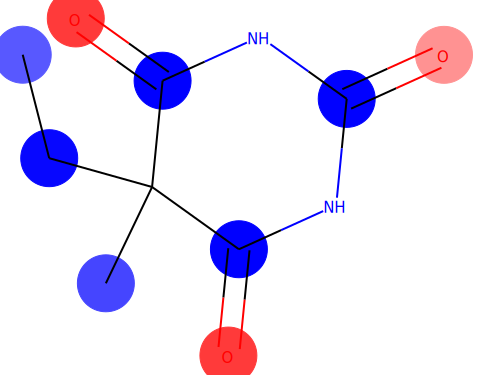

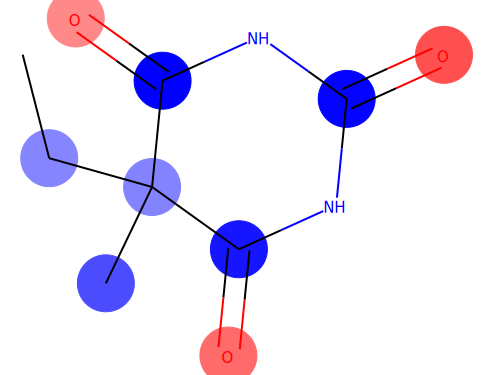

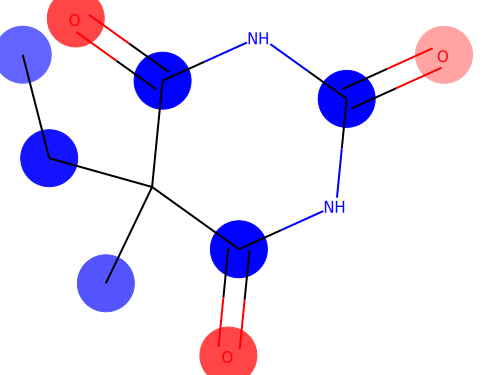

In [26]:
sv_visualize(i=128, ratio=0.7, method='raw', view='view')

In [27]:
interact(sv_visualize, i=(0, len(train) - 1, 1), ratio=(0, 1.0, 0.1), method=['raw'], view=['view', 'save'])

interactive(children=(IntSlider(value=450, description='i', max=901), FloatSlider(value=0.5, description='ratio', max=1.0), Dropdown(description='method', options=('raw',), value='raw'), Dropdown(description='view', options=('view', 'save'), value='view'), Output()), _dom_classes=('widget-interact',))

<function __main__.sv_visualize>

In [32]:
#!pip install cairosvg